In [1]:
import json
import pandas as pd
import numpy as np
import seaborn

In [3]:
from tqdm import tqdm
data_by_cat = {}

with open('/home/ubuntu/efs/lei/emerald_new/emerald.jsonl') as f:
    for line in tqdm(f):
        j = json.loads(line.strip())
        cat = j['category']
        if cat not in data_by_cat:
            data_by_cat[cat] = []
        data_by_cat[cat].append(line)
print(len(data_by_cat))

60024it [01:04, 924.33it/s] 

25


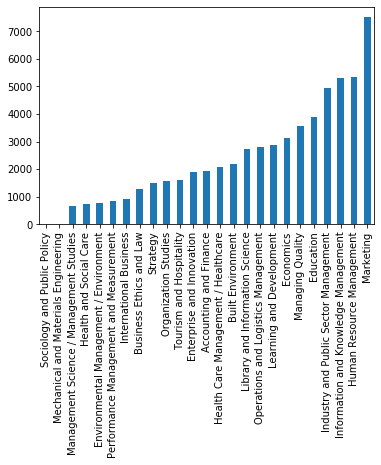

In [4]:
pd.Series({i:len(data_by_cat[i]) for i in data_by_cat}).sort_values().plot.bar()

In [5]:
train, dev, test = [], [], []

for cat in data_by_cat:
    # fix random seed
    np.random.seed(0)
    tuples = data_by_cat[cat]
    np.random.shuffle(tuples)
    train_, dev_, test_ = np.split(tuples, [int(0.8 * len(tuples)), int(0.9 * len(tuples))])
    
    train.extend(train_)
    dev.extend(dev_)
    test.extend(test_)

for i in (train, dev, test):
    # fix random seed
    np.random.seed(0)
    np.random.shuffle(i)

# force #dev and #test to be 6k
train.extend(test[-15:])
test = test[: -15]

len(train), len(dev), len(test)

(48024, 6000, 6000)

In [6]:
from collections import Counter

def count_by_cat(lines):
    return Counter(json.loads(line.strip())['category'] for line in lines)

In [7]:
a, b, c = count_by_cat(train), count_by_cat(dev), count_by_cat(test)

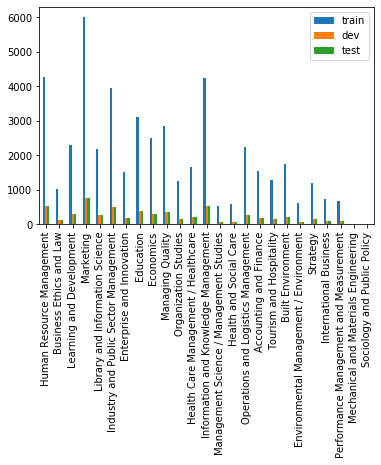

In [8]:
df = pd.DataFrame({'train': a, 'dev': b, 'test':c}).fillna(0).astype(np.float)
df.plot.bar()

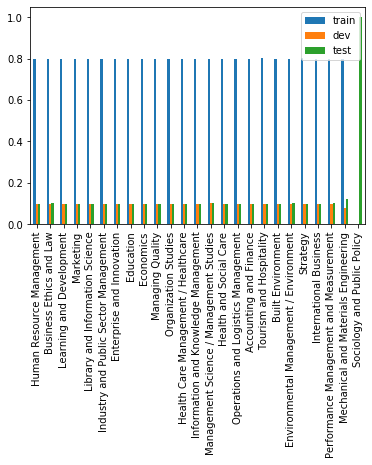

In [9]:
total = df['train'] + df['dev'] + df['test']
for i in ('train', 'dev', 'test'):
    df[i] = df[i] / total
df.plot.bar()

In [19]:
for obj, fname in zip((train, dev, test), ('train', 'dev', 'test')):
    print(fname, len(obj))
    with open(f'/home/ubuntu/efs/lei/emerald_new/{fname}.jsonl', 'w', encoding='utf8') as f:
        f.write(''.join(obj))


train 48024
dev 6000
test 6000


In [47]:
! mkdir /home/ubuntu/efs/emerald/old_data

In [49]:
! mv /home/ubuntu/efs/emerald/*.jsonl /home/ubuntu/efs/emerald/old_data/
! cp /home/ubuntu/efs/lei/emerald_new/*.jsonl /home/ubuntu/efs/emerald/

mv: cannot stat '/home/ubuntu/efs/emerald/*.jsonl': No such file or directory


### Rui

In [10]:
def lines2df(lines):
    ex_dicts = []
    for line in lines:
        ex_dict = json.loads(line.strip())
        ex_dicts.append(ex_dict)
    df = pd.DataFrame.from_records(ex_dicts, columns=list(ex_dicts[0].keys()))
    return df


In [25]:
lines = [l for l in open('/home/ubuntu/efs/lei/emerald_new/emerald.jsonl', 'r').readlines()]
emerald_df = lines2df(lines)
emerald_df.head(3)
emerald_df.groupby('category')['id'].nunique().sort_values(ascending=False).reset_index(name='count')

,category,count
0,Marketing,7508
1,Human Resource Management,5339
2,Information and Knowledge Management,5287
3,Industry and Public Sector Management,4948
4,Education,3900
5,Managing Quality,3582
6,Economics,3122
7,Learning and Development,2871
8,Operations and Logistics Management,2787
9,Library and Information Science,2723


### check if there's any overlap between splits

In [11]:
train_df = lines2df(train)
dev_df = lines2df(dev)
test_df = lines2df(test)

In [18]:
len(set(train_df.url.tolist()+dev_df.url.tolist()+test_df.url.tolist()))

60024